In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

1. 데이터 확인

In [2]:
#MNIST dataset

train_dset = datasets.MNIST('../data', train=True, download=True,transform=transforms.ToTensor())
test_dset = datasets.MNIST('../data', train=False,transform=transforms.ToTensor(), download=True)

print('number of training data: ', len(train_dset))
print('number of test data ', len(test_dset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

number of training data:  60000
number of test data  10000


Image
Shape of image	:  torch.Size([1, 28, 28])
10'th row of this image	: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3137,
        0.6118, 0.4196, 0.9922, 0.9922, 0.8039, 0.0431, 0.0000, 0.1686, 0.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
Label
label:  5


<function matplotlib.pyplot.show(close=None, block=None)>

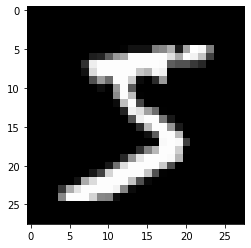

In [3]:
#데이터 확인

"""

TODO: train_dset[*] 의 숫자값을 바꾸어 데이터를 다른 걸 출력해보자.

"""
image, label = train_dset[0]

print('Image')
print('=========================================')
print('Shape of image\t: ', image.shape)
print('10\'th row of this image\t:', image[0][9])

print('Label')
print('=========================================')
print('label: ', label)

from matplotlib import pyplot as plt
# squeeze() 함수 : 크기가 1인 axis 제거
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.show

2. Training and Test

In [4]:
"""
TODO: batch_size 를 바꾸어보자
"""
train_loader = torch.utils.data.DataLoader(train_dset, batch_size = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size = 16, shuffle=False)

In [49]:
#Training
def train(model, train_loader, optimizer, i_epoch, device):
    model.train()
    accurate = 0
    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        output = model(image)
        loss = F.cross_entropy(output, target)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        prediction = torch.argmax(output, dim=1)
        accurate += prediction.eq(target.view_as(prediction)).sum().item()


         #러닝 커브 그리기
        loss_value.append(loss.detach().numpy())

        #100번쨰 마다 loss 출력
        if i%100==0:
            print("epoch: {}, iteration: {}, loss: {}".format(i_epoch, i, loss.item()))
    
    accuracy = accurate / len(train_loader.dataset)
    train_accuracy_value.append(accuracy)

In [50]:
#Test
def test(model, test_loader, i_epoch, device):
    model.eval()
    accurate = 0
    test_loss = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(test_loader):
            image = image.to(device)
            output = model(image)
            # nll_loss : negative log likelihood loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            prediction = torch.argmax(output, dim=1)
            # view_as : view this tensor as the same size as other
            accurate += prediction.eq(target.view_as(prediction)).sum().item()


    accuracy = accurate / len(test_loader.dataset)
    #러닝커브 그리기
    test_accuracy_value.append(accuracy)
    print("epoch: {},train_accuracy:{}, test_accuracy: {}".format(i_epoch, train_accuracy_value[i_epoch], test_accuracy_value[i_epoch]))


3. Model

In [91]:
"""
TODO: 모델 Customization! 레이어 개수나 레이어 차원, 활성화 함수를 바꾸어보자.

데이터의 형태를 주의하면서 바꾸어 볼 것~

"""

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
           )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

# layer를 1층 늘리기 
class net2(nn.Module):
    def __init__(self):
        super(net2, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
           )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)
    
# layer의 unit 수 늘리기 : 64 -> 256 
class net3(nn.Module):
    def __init__(self):
        super(net3, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Sigmoid()
           )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

4. Evaluation

In [92]:
loss_value = []
train_accuracy_value = []
test_accuracy_value = []
model = net()
#model2 = net2()
#model3 = net3()

"""

TODO: 학습률을 바꾸어보고, Optimizer 을 바꾸어보자 (선택)

"""
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
TODO: 학습횟수를 자유자재로 바꾸어보자.
"""

for i_epoch in range(40):
    train(model, train_loader, optimizer, i_epoch, device)
    test(model, test_loader, i_epoch, device)
    torch.save(model.state_dict(), "mnist_test.pt")

"""
 print('=========================================')
    print("Model's state_dict for epoch :", i_epoch)
    for param_tensor in model.state_dict():
     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    print("Optimizer's state_dict:")
     for var_name in optimizer.state_dict():
      print(var_name, "\t", optimizer.state_dict()[var_name])

    print('=========================================')
"""

epoch: 0, iteration: 0, loss: 2.3064017295837402
epoch: 0, iteration: 100, loss: 2.249382495880127
epoch: 0, iteration: 200, loss: 2.1772119998931885
epoch: 0, iteration: 300, loss: 2.047973155975342
epoch: 0, iteration: 400, loss: 1.9695568084716797
epoch: 0, iteration: 500, loss: 1.9713834524154663
epoch: 0, iteration: 600, loss: 1.9075515270233154
epoch: 0, iteration: 700, loss: 1.8350757360458374
epoch: 0, iteration: 800, loss: 1.8928239345550537
epoch: 0, iteration: 900, loss: 1.8442589044570923
epoch: 0, iteration: 1000, loss: 1.7911731004714966
epoch: 0, iteration: 1100, loss: 1.7168495655059814
epoch: 0, iteration: 1200, loss: 1.754547357559204
epoch: 0, iteration: 1300, loss: 1.6984976530075073
epoch: 0, iteration: 1400, loss: 1.8607312440872192
epoch: 0, iteration: 1500, loss: 1.7402653694152832
epoch: 0, iteration: 1600, loss: 1.6485296487808228
epoch: 0, iteration: 1700, loss: 1.6776539087295532
epoch: 0, iteration: 1800, loss: 1.7351529598236084
epoch: 0, iteration: 1900, 

epoch: 4, iteration: 300, loss: 1.656833529472351
epoch: 4, iteration: 400, loss: 1.5545992851257324
epoch: 4, iteration: 500, loss: 1.5228227376937866
epoch: 4, iteration: 600, loss: 1.5566644668579102
epoch: 4, iteration: 700, loss: 1.473783016204834
epoch: 4, iteration: 800, loss: 1.50018310546875
epoch: 4, iteration: 900, loss: 1.495585322380066
epoch: 4, iteration: 1000, loss: 1.5313924551010132
epoch: 4, iteration: 1100, loss: 1.5330760478973389
epoch: 4, iteration: 1200, loss: 1.5101256370544434
epoch: 4, iteration: 1300, loss: 1.567867398262024
epoch: 4, iteration: 1400, loss: 1.6696711778640747
epoch: 4, iteration: 1500, loss: 1.5117398500442505
epoch: 4, iteration: 1600, loss: 1.5267553329467773
epoch: 4, iteration: 1700, loss: 1.57245671749115
epoch: 4, iteration: 1800, loss: 1.4903286695480347
epoch: 4, iteration: 1900, loss: 1.535341501235962
epoch: 4, iteration: 2000, loss: 1.5630894899368286
epoch: 4, iteration: 2100, loss: 1.5885655879974365
epoch: 4, iteration: 2200, l

epoch: 8, iteration: 600, loss: 1.6072605848312378
epoch: 8, iteration: 700, loss: 1.5143940448760986
epoch: 8, iteration: 800, loss: 1.553816795349121
epoch: 8, iteration: 900, loss: 1.5211927890777588
epoch: 8, iteration: 1000, loss: 1.4827430248260498
epoch: 8, iteration: 1100, loss: 1.5191879272460938
epoch: 8, iteration: 1200, loss: 1.5580663681030273
epoch: 8, iteration: 1300, loss: 1.4852668046951294
epoch: 8, iteration: 1400, loss: 1.570419430732727
epoch: 8, iteration: 1500, loss: 1.579175353050232
epoch: 8, iteration: 1600, loss: 1.4835487604141235
epoch: 8, iteration: 1700, loss: 1.4734584093093872
epoch: 8, iteration: 1800, loss: 1.4945529699325562
epoch: 8, iteration: 1900, loss: 1.4766404628753662
epoch: 8, iteration: 2000, loss: 1.6787621974945068
epoch: 8, iteration: 2100, loss: 1.4806169271469116
epoch: 8, iteration: 2200, loss: 1.5895334482192993
epoch: 8, iteration: 2300, loss: 1.4727270603179932
epoch: 8, iteration: 2400, loss: 1.5615180730819702
epoch: 8, iteration

epoch: 12, iteration: 700, loss: 1.4697402715682983
epoch: 12, iteration: 800, loss: 1.5183398723602295
epoch: 12, iteration: 900, loss: 1.4945354461669922
epoch: 12, iteration: 1000, loss: 1.4695271253585815
epoch: 12, iteration: 1100, loss: 1.5357122421264648
epoch: 12, iteration: 1200, loss: 1.4987447261810303
epoch: 12, iteration: 1300, loss: 1.4850021600723267
epoch: 12, iteration: 1400, loss: 1.4754953384399414
epoch: 12, iteration: 1500, loss: 1.482130765914917
epoch: 12, iteration: 1600, loss: 1.5738236904144287
epoch: 12, iteration: 1700, loss: 1.4734363555908203
epoch: 12, iteration: 1800, loss: 1.4778988361358643
epoch: 12, iteration: 1900, loss: 1.5118423700332642
epoch: 12, iteration: 2000, loss: 1.4959505796432495
epoch: 12, iteration: 2100, loss: 1.5292038917541504
epoch: 12, iteration: 2200, loss: 1.5492767095565796
epoch: 12, iteration: 2300, loss: 1.4896656274795532
epoch: 12, iteration: 2400, loss: 1.5081311464309692
epoch: 12, iteration: 2500, loss: 1.48554873466491

epoch: 16, iteration: 700, loss: 1.4997284412384033
epoch: 16, iteration: 800, loss: 1.4957129955291748
epoch: 16, iteration: 900, loss: 1.4657530784606934
epoch: 16, iteration: 1000, loss: 1.488081932067871
epoch: 16, iteration: 1100, loss: 1.485388994216919
epoch: 16, iteration: 1200, loss: 1.4667720794677734
epoch: 16, iteration: 1300, loss: 1.4695535898208618
epoch: 16, iteration: 1400, loss: 1.536978006362915
epoch: 16, iteration: 1500, loss: 1.5294662714004517
epoch: 16, iteration: 1600, loss: 1.490044355392456
epoch: 16, iteration: 1700, loss: 1.4994304180145264
epoch: 16, iteration: 1800, loss: 1.5303500890731812
epoch: 16, iteration: 1900, loss: 1.582245945930481
epoch: 16, iteration: 2000, loss: 1.496181845664978
epoch: 16, iteration: 2100, loss: 1.542197585105896
epoch: 16, iteration: 2200, loss: 1.4953471422195435
epoch: 16, iteration: 2300, loss: 1.5314489603042603
epoch: 16, iteration: 2400, loss: 1.572211503982544
epoch: 16, iteration: 2500, loss: 1.4973318576812744
epoc

epoch: 20, iteration: 700, loss: 1.5243065357208252
epoch: 20, iteration: 800, loss: 1.4767998456954956
epoch: 20, iteration: 900, loss: 1.4652172327041626
epoch: 20, iteration: 1000, loss: 1.4890440702438354
epoch: 20, iteration: 1100, loss: 1.4852677583694458
epoch: 20, iteration: 1200, loss: 1.4764049053192139
epoch: 20, iteration: 1300, loss: 1.4789488315582275
epoch: 20, iteration: 1400, loss: 1.4846004247665405
epoch: 20, iteration: 1500, loss: 1.4653890132904053
epoch: 20, iteration: 1600, loss: 1.521804690361023
epoch: 20, iteration: 1700, loss: 1.4683372974395752
epoch: 20, iteration: 1800, loss: 1.5395863056182861
epoch: 20, iteration: 1900, loss: 1.4701874256134033
epoch: 20, iteration: 2000, loss: 1.4697623252868652
epoch: 20, iteration: 2100, loss: 1.4840266704559326
epoch: 20, iteration: 2200, loss: 1.5456137657165527
epoch: 20, iteration: 2300, loss: 1.4741804599761963
epoch: 20, iteration: 2400, loss: 1.520512580871582
epoch: 20, iteration: 2500, loss: 1.470987319946289

epoch: 24, iteration: 700, loss: 1.4707021713256836
epoch: 24, iteration: 800, loss: 1.5473556518554688
epoch: 24, iteration: 900, loss: 1.4933174848556519
epoch: 24, iteration: 1000, loss: 1.4751204252243042
epoch: 24, iteration: 1100, loss: 1.4831780195236206
epoch: 24, iteration: 1200, loss: 1.472456932067871
epoch: 24, iteration: 1300, loss: 1.4739130735397339
epoch: 24, iteration: 1400, loss: 1.4826740026474
epoch: 24, iteration: 1500, loss: 1.618055820465088
epoch: 24, iteration: 1600, loss: 1.5418388843536377
epoch: 24, iteration: 1700, loss: 1.472023367881775
epoch: 24, iteration: 1800, loss: 1.463981032371521
epoch: 24, iteration: 1900, loss: 1.470383882522583
epoch: 24, iteration: 2000, loss: 1.4818694591522217
epoch: 24, iteration: 2100, loss: 1.5414979457855225
epoch: 24, iteration: 2200, loss: 1.4765856266021729
epoch: 24, iteration: 2300, loss: 1.4980442523956299
epoch: 24, iteration: 2400, loss: 1.560036540031433
epoch: 24, iteration: 2500, loss: 1.46486234664917
epoch: 

epoch: 28, iteration: 700, loss: 1.4726580381393433
epoch: 28, iteration: 800, loss: 1.4714781045913696
epoch: 28, iteration: 900, loss: 1.5785273313522339
epoch: 28, iteration: 1000, loss: 1.5142937898635864
epoch: 28, iteration: 1100, loss: 1.479032278060913
epoch: 28, iteration: 1200, loss: 1.539494514465332
epoch: 28, iteration: 1300, loss: 1.550016164779663
epoch: 28, iteration: 1400, loss: 1.5034728050231934
epoch: 28, iteration: 1500, loss: 1.487766981124878
epoch: 28, iteration: 1600, loss: 1.4711360931396484
epoch: 28, iteration: 1700, loss: 1.475306510925293
epoch: 28, iteration: 1800, loss: 1.471225619316101
epoch: 28, iteration: 1900, loss: 1.4795222282409668
epoch: 28, iteration: 2000, loss: 1.4849945306777954
epoch: 28, iteration: 2100, loss: 1.4654183387756348
epoch: 28, iteration: 2200, loss: 1.4668537378311157
epoch: 28, iteration: 2300, loss: 1.4672447443008423
epoch: 28, iteration: 2400, loss: 1.4822684526443481
epoch: 28, iteration: 2500, loss: 1.466929316520691
epo

epoch: 32, iteration: 700, loss: 1.4811656475067139
epoch: 32, iteration: 800, loss: 1.487295150756836
epoch: 32, iteration: 900, loss: 1.461896300315857
epoch: 32, iteration: 1000, loss: 1.5326833724975586
epoch: 32, iteration: 1100, loss: 1.47844398021698
epoch: 32, iteration: 1200, loss: 1.4638805389404297
epoch: 32, iteration: 1300, loss: 1.5281447172164917
epoch: 32, iteration: 1400, loss: 1.4732990264892578
epoch: 32, iteration: 1500, loss: 1.4850465059280396
epoch: 32, iteration: 1600, loss: 1.476791501045227
epoch: 32, iteration: 1700, loss: 1.4967215061187744
epoch: 32, iteration: 1800, loss: 1.469330906867981
epoch: 32, iteration: 1900, loss: 1.4641926288604736
epoch: 32, iteration: 2000, loss: 1.487766146659851
epoch: 32, iteration: 2100, loss: 1.4615529775619507
epoch: 32, iteration: 2200, loss: 1.4873542785644531
epoch: 32, iteration: 2300, loss: 1.4992022514343262
epoch: 32, iteration: 2400, loss: 1.4754763841629028
epoch: 32, iteration: 2500, loss: 1.4635601043701172
epo

epoch: 36, iteration: 700, loss: 1.5174899101257324
epoch: 36, iteration: 800, loss: 1.464660406112671
epoch: 36, iteration: 900, loss: 1.4932210445404053
epoch: 36, iteration: 1000, loss: 1.4770299196243286
epoch: 36, iteration: 1100, loss: 1.5428338050842285
epoch: 36, iteration: 1200, loss: 1.4643266201019287
epoch: 36, iteration: 1300, loss: 1.5250177383422852
epoch: 36, iteration: 1400, loss: 1.5450881719589233
epoch: 36, iteration: 1500, loss: 1.4764599800109863
epoch: 36, iteration: 1600, loss: 1.4812986850738525
epoch: 36, iteration: 1700, loss: 1.4643943309783936
epoch: 36, iteration: 1800, loss: 1.4677797555923462
epoch: 36, iteration: 1900, loss: 1.467261552810669
epoch: 36, iteration: 2000, loss: 1.5108778476715088
epoch: 36, iteration: 2100, loss: 1.468472957611084
epoch: 36, iteration: 2200, loss: 1.4688727855682373
epoch: 36, iteration: 2300, loss: 1.462707281112671
epoch: 36, iteration: 2400, loss: 1.472011685371399
epoch: 36, iteration: 2500, loss: 1.4909279346466064
e

'\n print(\'=========================================\')\n    print("Model\'s state_dict for epoch :", i_epoch)\n    for param_tensor in model.state_dict():\n     print(param_tensor, "\t", model.state_dict()[param_tensor].size())\n\n    print("Optimizer\'s state_dict:")\n     for var_name in optimizer.state_dict():\n      print(var_name, "\t", optimizer.state_dict()[var_name])\n\n    print(\'=========================================\')\n'

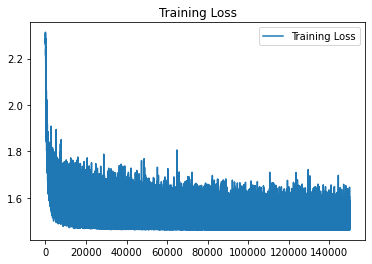

In [94]:
#그래프 확인
plt.plot(loss_value, label='Training Loss')
plt.title('Training Loss')
plt.legend()

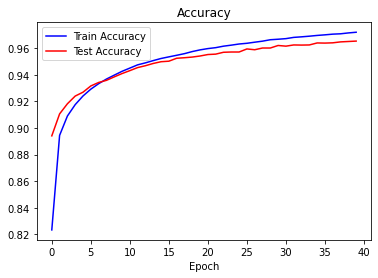

In [95]:
plt.plot(train_accuracy_value, label='Train Accuracy', c = 'b')
plt.plot(test_accuracy_value, label='Test Accuracy', c= 'r')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [96]:
len(train_accuracy_value)

40

In [97]:
print(test_accuracy_value[-1])

0.9653
